### K-Nearest Neighbors ###

KNN is a algorithm that classifies data based on the majority class among their k closest neighbors in the feature space. We will implement KNN from scratch and apply it to the Wine Quality dataset to predict whether a win is "good" or "bad".

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Set theme for plotting
sns.set_theme()

python(64007) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


To determine how "close" two points are, we use Euclidean distance. This metric measures the straight-line distance between two points in multi-dimensional space and forms the foundation of neighbor selection in KNN.

In [46]:
def distance(p, q):
    return np.sqrt((p - q) @ (p - q))

 

With a distance function defined, we can now loop through all training points to find the k closest ones to a new data point. 

In [47]:
def k_nearest_neighbors(point, 
                        training_features, 
                        training_labels, 
                        k):
    # Create an empty list to store neighbors and distances
    neighbors = []
    
    for p, label in zip(training_features, training_labels):
        d = distance(point, p)
        temp_data = [p, label, d]
        neighbors.append(temp_data)
        
    neighbors.sort(key = lambda x : x[-1])
    
    return neighbors[:k]

With a function to compute the k nearest neighbors to a point, we can now write a function to predict a target label. 

In [48]:
def KNN_Predict(point, 
                training_features, 
                training_labels, 
                k, 
                regression = False):
    
    neighbors = k_nearest_neighbors(point, 
                                    training_features, 
                                    training_labels, 
                                    k)
    
    if regression == False:
        labels = [x[1] for x in neighbors]
        return max(labels, key = labels.count)
    
    else:
        return sum(x[1] for x in neighbors)/k

We can compute the classification error using the function below:

In [49]:
def classification_error(test_features, 
                         test_labels,
                         training_features, 
                         training_labels,
                         k):
    error = 0
    for point, label in zip(test_features, test_labels):
        error += label != KNN_Predict(point, 
                                      training_features, 
                                      training_labels, 
                                      k)
    return error/len(test_features)

We use the red wine data from the winequality-red.csv dataset. The target variable is converted into binary classes:
- Good Wine: quality ≥ 7
- Bad Wine: quality < 7



In [50]:

# Load the Wine Quality dataset

df = pd.read_csv("Datasets/winequality-red.csv")

# Convert quality to binary classification (good/bad)
# Let's say quality ≥ 7 is "good" (1), < 7 is "bad" (0)
df['quality'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)

# Select specific features
selected_features = ['alcohol', 'density', 'pH']
X = df[selected_features]
y = df['quality'] 


# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




Let's visualize the feature space. This helps build intuition if KNN is appropriate.

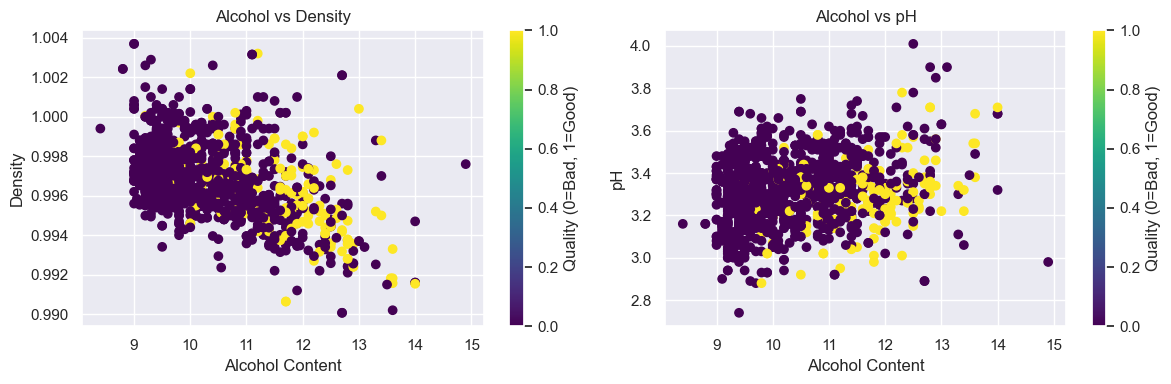

In [51]:

# Let's visualize these features first
plt.figure(figsize=(12, 4))
# Plot alcohol vs density
plt.subplot(1, 2, 1)
plt.scatter(X_train['alcohol'], X_train['density'], c=y_train, cmap='viridis')
plt.title('Alcohol vs Density')
plt.xlabel('Alcohol Content')
plt.ylabel('Density')
plt.colorbar(label='Quality (0=Bad, 1=Good)')

# Plot alcohol vs pH
plt.subplot(1, 2, 2)
plt.scatter(X_train['alcohol'], X_train['pH'], c=y_train, cmap='viridis')
plt.title('Alcohol vs pH')
plt.xlabel('Alcohol Content')
plt.ylabel('pH')
plt.colorbar(label='Quality (0=Bad, 1=Good)')

plt.tight_layout()
plt.show()

Let's evaluate different k values to observe how accuracy changes.

In [52]:
def predict(X_test, X_train, y_train, k):
    predictions = []
    for test_point in X_test:
        # Get k nearest neighbors
        nearest = k_nearest_neighbors(test_point, X_train, y_train, k)
        # Get labels of k nearest neighbors
        k_nearest_labels = [item[1] for item in nearest]  # Get the labels (index 1)
        # Find most common label
        prediction = max(set(k_nearest_labels), key=k_nearest_labels.count)
        predictions.append(prediction)
    return predictions

# Test different k values
k_values = [1, 3, 5, 7, 11, 13, 21]
best_k = 1
accuracies=[]
best_accuracy = 0

for k in k_values:
    predictions = predict(X_test_scaled, X_train_scaled, y_train, k)
    accuracy = np.mean(np.array(predictions) == y_test)  # Convert to array for comparison
    accuracies.append(accuracy)
    print(f"K={k}, Accuracy: {accuracy:.4f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"\nBest K value: {best_k} with accuracy: {best_accuracy:.4f}")



K=1, Accuracy: 0.8531
K=3, Accuracy: 0.8344
K=5, Accuracy: 0.8281
K=7, Accuracy: 0.8469
K=11, Accuracy: 0.8469
K=13, Accuracy: 0.8438
K=21, Accuracy: 0.8469

Best K value: 1 with accuracy: 0.8531


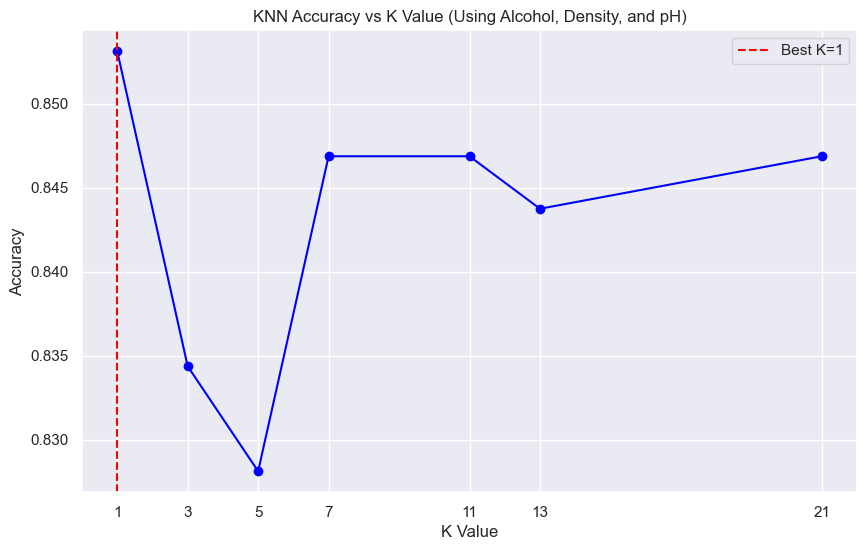

In [53]:
# Plot accuracy vs K
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue')
plt.title('KNN Accuracy vs K Value (Using Alcohol, Density, and pH)')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(k_values)
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best K={best_k}')
plt.legend()
plt.show()

After identifying the best k value, we can evaluate performance:


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       273
           1       0.50      0.60      0.54        47

    accuracy                           0.85       320
   macro avg       0.71      0.75      0.73       320
weighted avg       0.87      0.85      0.86       320



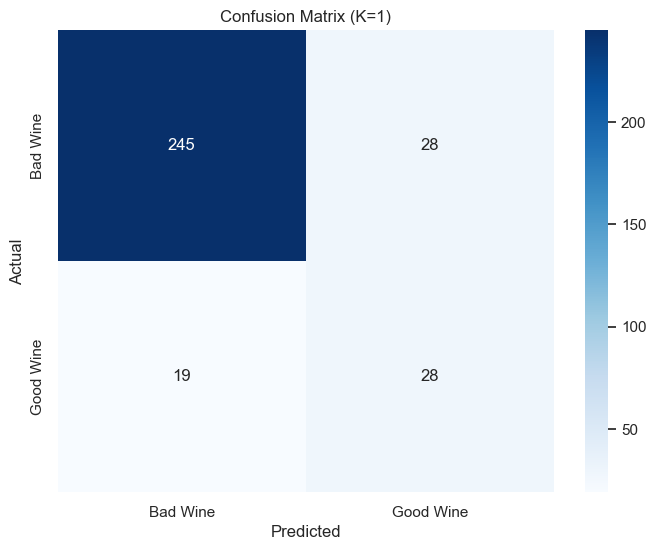

In [54]:
# Evaluate with best k
predictions = predict(X_test_scaled, X_train_scaled, y_train, best_k)

# Convert predictions to array for classification report and confusion matrix
predictions = np.array(predictions)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad Wine', 'Good Wine'],
            yticklabels=['Bad Wine', 'Good Wine'])
plt.title(f'Confusion Matrix (K={best_k})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Findings #

The model achieved its highest accuracy of 0.8531 when using K=1, indicating that the selected features (alcohol, density, and pH) create relatively clear boundaries between good and bad wines.

Looking at the confusion matrix, the model is particularly good at identifying bad wines, as we can see a high number of True Negatives. 
From the classficaiton report we can also see that the F1 score is high for bad wines, indicating a better overall performance for bad wine classificaition. However, from the support column, we can clearly see the imbalance between classes (there are way more bad wines than good wines). Due to this, the model's performance is skewed due to having more bad wines in the dataset.

Limitations: The model's use of just three features might be limiting its ability to capture more complex quality indicators. Using K=1, while providing high accuracy, might not generalize well to unseen wines.
